# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) and pandas. 
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: *** 207380528, 302673355 ***

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

plt.style.use('seaborn')
sns.set(font_scale=1.2)
# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

In [4]:
training_set.sample(5)

,x1,x2,y
100,-2.201917,4.244907,0
1825,5.344807,1.836256,1
170,-0.133526,6.297545,0
1159,4.052065,7.286774,0
1266,3.785888,8.380817,0


In [5]:
training_set.describe()

,x1,x2,y
count,2000.000000,2000.000000,2000.00000
mean,0.844608,5.864061,0.40000
std,4.051899,2.593666,0.49002
min,-7.659203,-1.219830,0.00000
25%,-2.897422,4.160386,0.00000
50%,1.251215,5.859231,0.00000
75%,4.565506,7.664301,1.00000
max,8.612389,13.614355,1.00000


## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

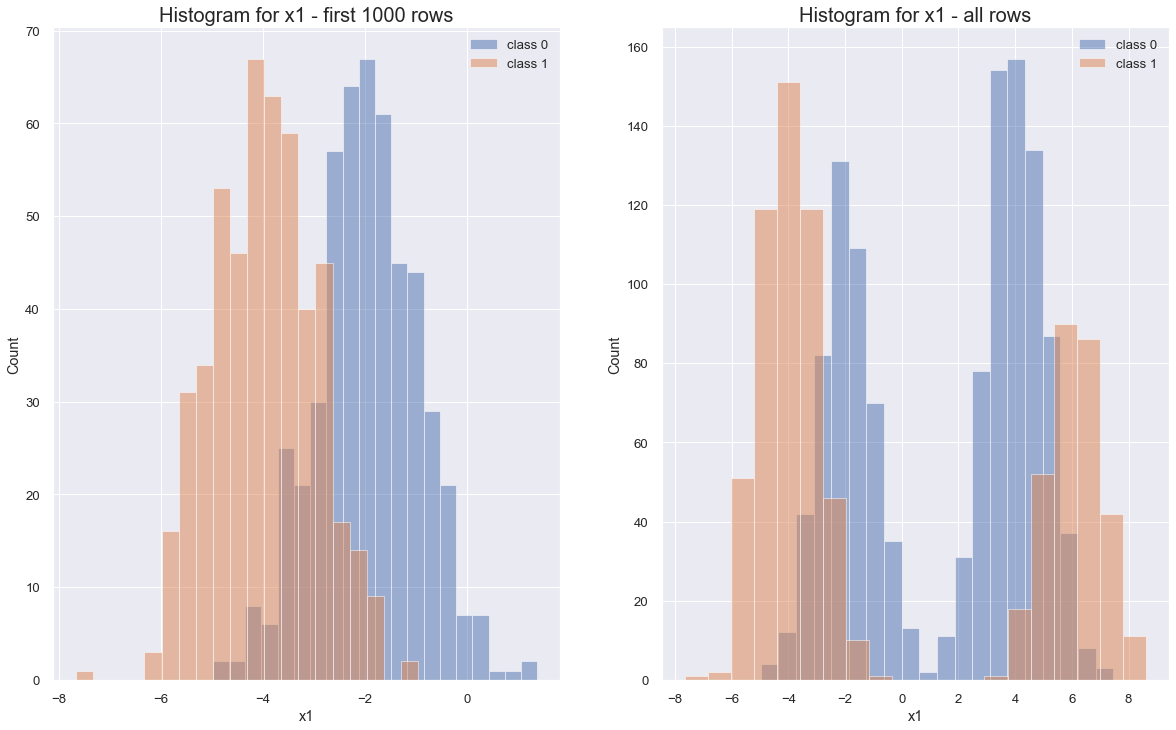

In [6]:
#### Your code here ####

# for the first feature only:

#   1. first 1000 points
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 12))
ax[0].hist(training_set[:1000]['x1'][training_set['y']==0], bins=20, alpha=0.5, label="class 0")
ax[0].hist(training_set[:1000]['x1'][training_set['y']==1], bins=20, alpha=0.5, label="class 1")
ax[0].set_title('Histogram for x1 - first 1000 rows', fontsize=20)
ax[0].legend()
ax[0].set_xlabel("x1")
ax[0].set_ylabel("Count")

#   2. all points
ax[1].hist(training_set[training_set.y == 0]["x1"].values, bins=20,  alpha=0.5, label="class 0")
ax[1].hist(training_set[training_set.y == 1]["x1"].values, bins=20,  alpha=0.5, label="class 1")
ax[1].set_title('Histogram for x1 - all rows', fontsize=20)
ax[1].legend()
ax[1].set_xlabel("x1")
ax[1].set_ylabel("Count")

plt.show()

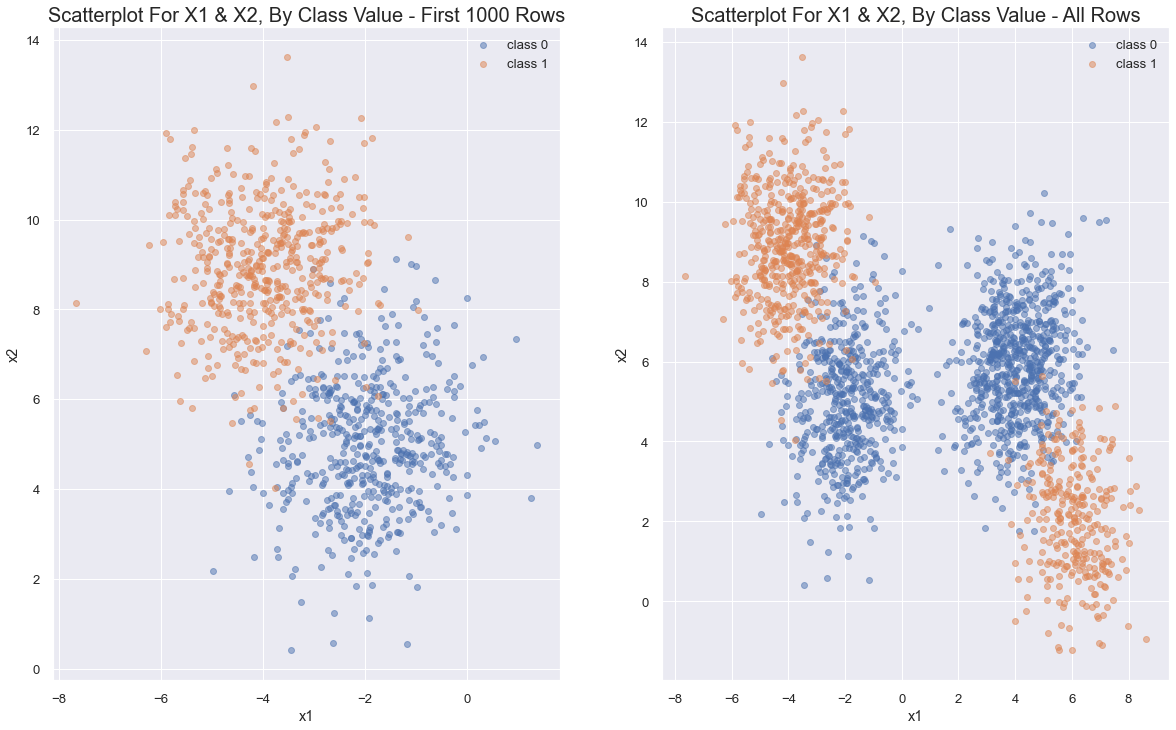

In [7]:

# for both the features:

#   1. first 1000 points
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 12))
ax[0].scatter(training_set.iloc[: 1000][training_set.y == 0]["x1"].values, training_set.iloc[: 1000][training_set.y == 0]["x2"].values, alpha=0.5, label="class 0")
ax[0].scatter(training_set.iloc[: 1000][training_set.y == 1]["x1"].values, training_set.iloc[: 1000][training_set.y == 1]["x2"].values, alpha=0.5, label="class 1")
ax[0].set_title('Scatterplot for x1 & x2, by class value - first 1000 rows'.title(), fontsize=20)
ax[0].legend()
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")

#   2. all points
ax[1].scatter(training_set[training_set.y == 0]["x1"].values, training_set[training_set.y == 0]["x2"].values, alpha=0.5, label="class 0")
ax[1].scatter(training_set[training_set.y == 1]["x1"].values, training_set[training_set.y == 1]["x2"].values, alpha=0.5, label="class 1")
ax[1].set_title('Scatterplot for x1 & x2, by class value - all rows'.title(), fontsize=20)
ax[1].legend()
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x2")

plt.show()

## Logistic Regression

(15 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [8]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state

        self.theta = None
        self.J_list = list()
        
    @staticmethod
    def add_bias_vector(X):
        return np.c_[np.ones(len(X)), X]

    @staticmethod
    def sigmoid(X, theta):
        return 1 / (1 + np.exp(X.dot(-theta))) 

    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        X = self.add_bias_vector(X)
        
        # theta init
        np.random.seed(self.random_state)
        self.theta = np.random.random(X.shape[1])

        last_J = np.inf
        J = float()
        for _iter in range(self.n_iter):
          # forward prop (calc values & loss, aka J, aka cost)
          output = self.sigmoid(X, self.theta)
          J = self.compute_J(output, y)
          self.J_list.append(J)

          # backprop (calc gradient & update theta with the lr)
          self.theta = self.theta - self.eta * (output - y) @ X

          # check for convergence
          difference_J = last_J - J
          if difference_J < self.eps:
            break

          last_J = J 

    @staticmethod
    def compute_J(output, y):
      return ( ( -y  @ np.log(output) ) - ( (1 - y) @ np.log(1 - output) ) ) / len(y)
      
    def predict(self, X):
        """Return the predicted class label"""
        X = self.add_bias_vector(X)
        predictions = self.sigmoid(X, self.theta)
        predictions[predictions > 0.5] = 1
        predictions[predictions <= 0.5] = 0

        return predictions
    
    def accuracy(self, X, y):
        predictions = self.predict(X)
        acc = np.sum(predictions == y) / len(y)
        return acc

In [9]:
logit_reg = LogisticRegressionGD()
logit_reg.fit(X=X_training, y=y_training)
logit_reg.accuracy(X=X_training, y=y_training), logit_reg.accuracy(X=X_test, y=y_test)


(0.809, 0.804)

## Cross Validation

(5 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [10]:
#### Your code here ####
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

RANDOM_SEED = 123

def Kfold_accuracy(X, y, model: LogisticRegressionGD, k=5):
    """
    A function that evaluated a model object with a predict method.
    Calculates accuracy over K folds of the data, and returns its mean.
    Could be extented to use f1, recall precision, etc as well, but not currently.
    """
    temp_data = np.column_stack((X, y))

    np.random.seed(RANDOM_SEED)
    np.random.shuffle(temp_data)

    X, y = temp_data[:, : -1], temp_data[:, -1]    

    fold_size = len(y) // k
    start_test_fold = 0
    end_test_fold = fold_size
    accuracies_list = list()
    for _fold in range(k):
        # train
        X_train_fold = np.concatenate( (X[: start_test_fold], X[end_test_fold: ] ), axis=0) # concat rows before and after the test partition of the X
        y_train_fold = np.concatenate( (y[: start_test_fold], y[end_test_fold: ] ), axis=0) # concat rows before and after the test partition of the y
                
        # test
        X_test_fold = X[start_test_fold: end_test_fold]
        y_test_fold = y[start_test_fold: end_test_fold]

        
        model.fit(X_train_fold, y_train_fold)
        acc = model.accuracy(X_test_fold, y_test_fold)
        accuracies_list.append(acc)
        
        start_test_fold += fold_size
        end_test_fold += fold_size

        if _fold == k-1:  # if it's the last iteration
            end_test_fold = -1  # take all the remaining rows

    return np.mean(accuracies_list)


# main loops, to perform grid search
K = 5
max_avg_accuracy = 0
for eta in etas: 
    for eps in epss:
        model = LogisticRegressionGD(eta=eta, eps=eps)
        avg_accuracy = Kfold_accuracy(X=X_training, y=y_training, model=model, k=K)
        if avg_accuracy > max_avg_accuracy:
            print(f"Updated eta to: {eta}, eps to: {eps}")
            max_avg_accuracy = avg_accuracy
            best_eta, best_eps = eta, eps

print(f"The best Logistic regression model with mean Accuracy over k folds is: {max_avg_accuracy:.5f}. it's with eta = {best_eta}, eps = {best_eps}")

best_model = LogisticRegressionGD(eta=best_eta, eps=best_eps)



Updated eta to: 0.05, eps to: 0.01
Updated eta to: 0.0005, eps to: 0.01
Updated eta to: 5e-05, eps to: 1e-05
Updated eta to: 5e-05, eps to: 1e-06
The best Logistic regression model with mean Accuracy over k folds is: 0.79750. it's with eta = 5e-05, eps = 1e-06


## Normal distribution pdf

(2 Points)

Implement the normal distribution pdf 

$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$

Write an efficient vectorized code

In [11]:
#### Your code here ####
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    return np.exp( -1 / 2 * (((data - mu) / sigma) ** 2)) / ( sigma * np.sqrt(2 * np.pi) )


## Expectation Maximization

(15 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [12]:

    
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01, random_state=42):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state

        self.params = {}
        self.all_Js = []

    
    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        np.random.seed(self.random_state)
        data_mean = np.mean(data)
        data_std = np.std(data)
        
        for dist in range(self.k):
            self.params.update({dist: {"mu": np.random.random(), 
                               "sigma": np.random.random(),
                               "w": 1 / self.k}})
        # for dist in range(self.k):
        #     self.params.update({dist: {"mu": np.random.random(), 
        #                        "sigma": np.random.random(),
        #                        "w": 1 / self.k}})
        return self.params
        
        
    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        denominator = 0
        numerators = []
        for dist in range(self.k):
            likelihood = norm_pdf(data.T, self.params[dist]["mu"], self.params[dist]["sigma"])
            numerator = self.params[dist]["w"] * likelihood # get the numerator
            numerators.append(numerator)

        denominator = np.sum(numerators, axis=0)
        responsibilities = np.array(numerators) / denominator

        # shape of responsibilities is (k, rows) because each feature has 'k' interior distibutions. (and we do it for each feature later)
        return responsibilities

    
    def maximization(self, data, responsibilities):
        """
        M step - updating distribution params
        """
        responsibilities_means = np.mean(responsibilities, axis=1)
        N = len(data)
        for dist in range(self.k):
            new_w = responsibilities_means[dist]
            new_den = (new_w * len(data))
            new_mu = np.sum(data.dot(responsibilities[dist, : ])) / (new_den)  
            new_sig = np.sqrt( np.sum(( (data - new_mu) ** 2 ).dot(responsibilities[dist, : ])) / (new_den)  )

            self.params[dist].update({
                "mu": new_mu,
                "sigma": new_sig,
                "w": new_w
            })
        
        return 

    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        params = self.init_params(data)
        last_J = np.inf
        for _ in range(self.n_iter):
            responsibilities = self.expectation(data) # E
            self.maximization(data, responsibilities) # M
                
            J = np.sum([self.calc_cost(data, params[dist]["w"], params[dist]["mu"], params[dist]["sigma"]) for dist in self.params])
            self.all_Js.append(J)
            
            if abs(last_J - J) < self.eps:
                return self.params
            
            last_J = J

        return 

    def get_dist_params(self):
        return self.params
    
    def calc_cost(self, data, w, mu, sigma):
        return np.sum(-np.log2(w * norm_pdf(data, mu, sigma)))
        

## Naive Bayes

(15 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [13]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, num_classes=2):
        self.k = k
        self.num_classes = num_classes
        self.priors = []
        self.feature_class_distribution_params = {}

    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        self.dims = X.shape[1]
        class_values = np.unique(y)
        self.priors = np.array( [np.sum(y == class_value) / len(y) for class_value in class_values ] )
        
        for c in range(self.num_classes):
            for feat in range(self.dims):
                filtered_data = X[y == c, feat]
                em = EM(k=self.k)
                em.fit(filtered_data)

                self.feature_class_distribution_params[(feat, c)] = em.get_dist_params()

    @staticmethod
    def gmm_likelihood(data, params):
      w_vector = [params[dist]["w"] for dist in params]
      mu_vector = [params[dist]["mu"] for dist in params]
      sigma_vector = [params[dist]["sigma"] for dist in params]
      norms_per_k = [norm_pdf(data, mu_vector[k], sigma_vector[k]) for k in range(len(w_vector))]
      likelihoods = np.multiply(np.array(norms_per_k).T, w_vector)
      return np.sum(likelihoods, axis=1)

    def predict(self, X):
        """Return the predicted class label"""
        posteriors_by_class = list() 
        for class_value in range(self.num_classes):  # class_value == class_index in our case...
            row_features_likelihoods = list()  # for each feature, there is its corresponding likelihood, then we need to multiply for each row to get the row posterior, for each class
            for feature in range(self.dims):
                feature_likelihoods = self.gmm_likelihood(data=X[: , feature], params=self.feature_class_distribution_params[(feature, class_value)])
                row_features_likelihoods.append(feature_likelihoods)
            
            row_likelihoods = np.multiply(*row_features_likelihoods)  # for each row, the likelihood to see what we saw (given the normal parameters for the gmm)
            posteriors_by_class.append(np.multiply(row_likelihoods, self.priors[class_value])) # posterior = likelihood * prior

        predictions = np.argmax(posteriors_by_class, axis=0)  # for each row, return the class with the max posterior

        return predictions

    def accuracy(self, X, y):
        predictions = self.predict(X)
        return sum(predictions == y) / len(X)



## Model evaluation

(20 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

In [15]:
plt.rcParams['figure.figsize'] = (16.0, 10.0) # set default size of plots

plt.style.use('seaborn')
sns.set(font_scale=1.5)

def evaluate_model(model, X_train, y_train, X_test, y_test, logit_regression=False):
    model.fit(X_train, y_train)
    train_acc = model.accuracy(X_train, y_train)
    test_acc = model.accuracy(X_test, y_test)
    print(f'Train accuracy: {train_acc}\nTest accuracy: {test_acc}')

    # plot
    plot_decision_regions(X_train, y_train, model)
    
    if logit_regression: # plot cost vs. iteration, for logistic regression
        plt.subplots(1)
        plt.plot(np.arange(len(model.J_list)), model.J_list)
        plt.xlabel('Iteration')
        plt.ylabel('Cost')
        plt.title('Cost by iteration for logistic regression'.title())

First 1000 points

For logistic regression model on 1000 first rows
Train accuracy: 0.965
Test accuracy: 0.938


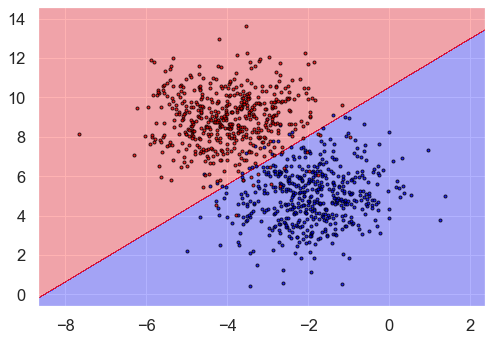

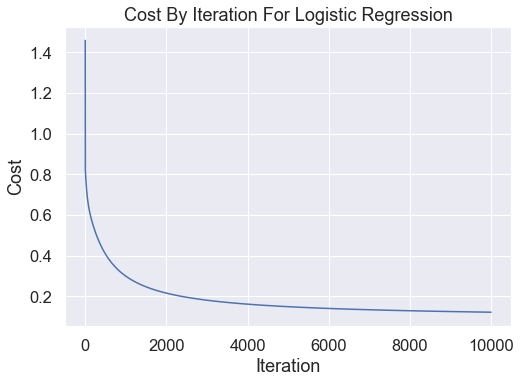

In [16]:
print("For logistic regression model on 1000 first rows")
lr = LogisticRegressionGD(eta=best_eta, eps=best_eps)
evaluate_model(lr, X_training[:1000], y_training[:1000], X_test[:500], y_test[:500], logit_regression=True)

We see that the data is clearly linearly separable, and that the cost decreases rapidly in the first 2K iterations, and afterwards decreases in a much slower pace.

Based on the histograms we plotted earlier, we chose k=1 for the first 1000 rows.

For Naive Bayes model on 1000 first rows (with k=1)
Train accuracy: 0.966
Test accuracy: 0.942


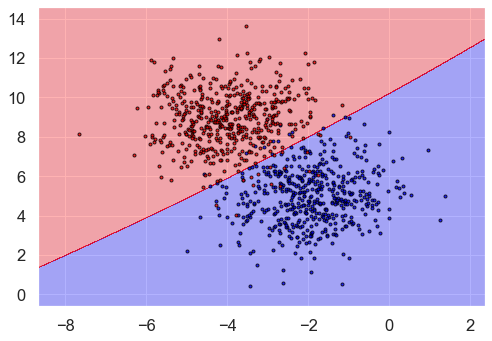

In [17]:
print("For Naive Bayes model on 1000 first rows (with k=1)")

nb = NaiveBayesGaussian(k=1, num_classes=2)
evaluate_model(nb, X_training[:1000], y_training[:1000], X_test[:500], y_test[:500], logit_regression=False)

We see that the data is clearly linearly separable, and that NB has found the 'linear function' as well.

Using all data

For logistic regression model on all data
Train accuracy: 0.809
Test accuracy: 0.804


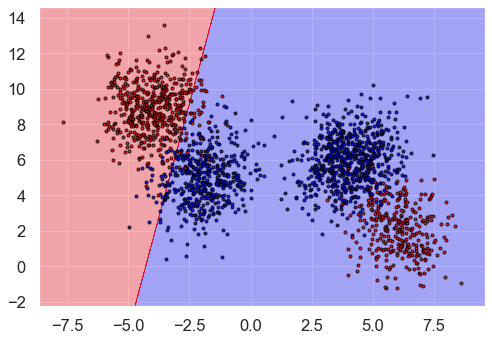

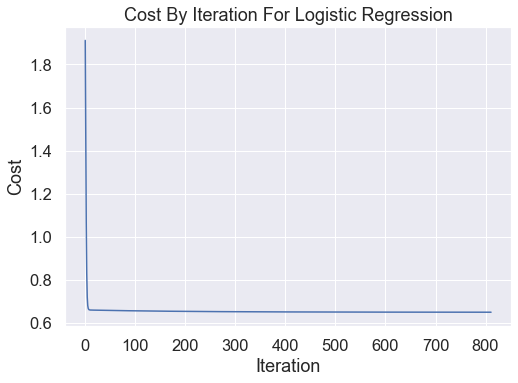

In [18]:
print("For logistic regression model on all data")
lr = LogisticRegressionGD(eta=best_eta, eps=best_eps)
evaluate_model(lr, X_training, y_training, X_test, y_test, logit_regression=True)

We see that the LR does not do a good job in classifying, and leaves a lot of wrongfully labeled data on the right-hand side of the regression line. We see that LR reaches the “optimal” line quickly and that cost only slightly decrease afterwards. Furthermore, we don’t even reach the 10K iterations and stop after around 800 iterations, as the cost decreases in less than epsilon.

Based on the histograms we plotted earlier, we chose k=2 for all the data.

For Naive Bayes model on all data (with k=2)
Train accuracy: 0.9005
Test accuracy: 0.889


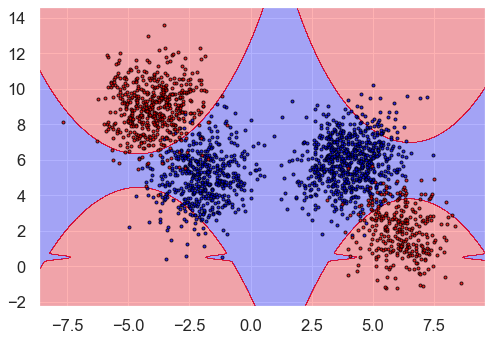

In [19]:
print("For Naive Bayes model on all data (with k=2)")

nb = NaiveBayesGaussian(k=2, num_classes=2)
evaluate_model(nb, X_training, y_training, X_test, y_test, logit_regression=False)

We see that NB has reached a non-linear function quite well (with test accuracy of near 90%).

## Open question

(20 points) 

1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
   1. Generate a dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Naive Bayes will work better than Logisitc Regression**.
   2. Generate another dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Logistic Regression will work better than Naive Bayes**.
   
   - Explain the reasoning behind each dataset.  

2. Visualize the datasets.  
   You can choose one of two options for the visualization:
    1. Plot three 2d graphs of all the features against each other (feature1 vs feature2, feature1 vs feature3, feature2 vs feature3).
    2. Plot one 3d graph.

**Important Note**  
For this question only, you may use:  
```
from scipy.stats import multivariate_normal
```

#### Your code and explanations here ####


Logistic Regression works better than Naïve Bayes when the data is linearly separable, while if the data is intertwined then we should expect the NB to work better.
Therefore, for the logistic regression to work better than naive bayes, we'll create a linearly seperable data (with GMM) that is dependant in its features.
While for the naive bayes to work better than LR, we'll create data that is not as linearly seperable, and is NOT dependent in its features - to make the naiveness of the model be realistic.

#### LR better than NB

In [24]:
# logistic regression better than naive bayes
# for that we'll create a GMM (it's not linearly seperbale that way)

mu_vector = np.array([-2, 0, 2])
cov_matrix = np.eye(3) + 2
SIZE = 1000
part1_size = int(SIZE / 2)

first_multi_normal = np.random.multivariate_normal(mu_vector, cov_matrix, size=part1_size)
second_multi_normal = np.random.multivariate_normal(mu_vector[: : -1], cov_matrix, size=part1_size)
data = np.concatenate((first_multi_normal, second_multi_normal), axis=0)

x1, x2, x3 = data[:, 0], data[:, 1], data[:, 2]
y = np.concatenate((np.zeros((part1_size, 1)), np.ones((part1_size, 1))), axis=0)  # labels

logistic_better_df = pd.DataFrame({"x1": x1, "x2": x2, "x3": x3, "y": y.reshape(-1, )})
logistic_better_df


,x1,x2,x3,y
0,-1.935105,-0.133725,3.050190,0.0
1,-0.261398,1.957674,5.569974,0.0
2,-1.747322,-0.307543,2.323955,0.0
3,-4.374643,-1.658465,1.018948,0.0
4,-5.448111,-3.405072,-1.130243,0.0
...,...,...,...,...
995,3.407852,-0.816556,-0.552295,1.0
996,2.220458,1.526310,-3.038074,1.0
997,3.141719,-1.629071,-1.978376,1.0
998,3.671283,0.167340,-0.699618,1.0


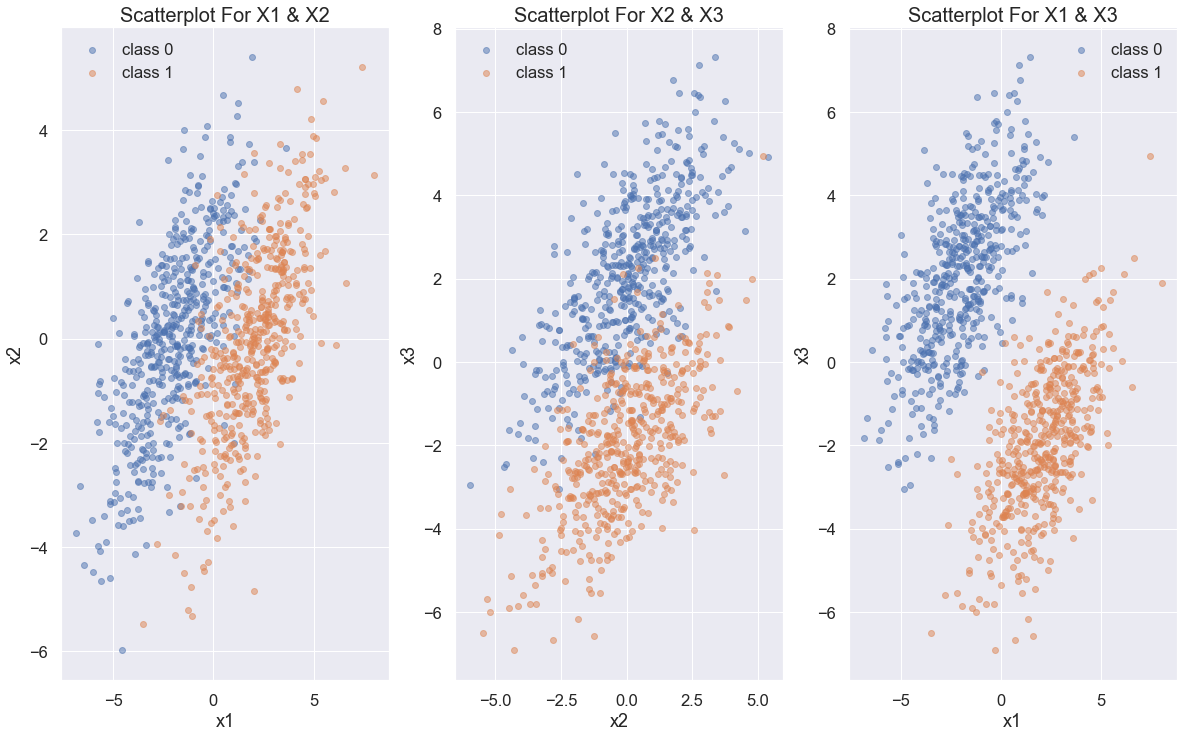

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 12))
ax[0].scatter(logistic_better_df[logistic_better_df.y == 0]["x1"].values, logistic_better_df[training_set.y == 0]["x2"].values, alpha=0.5, label="class 0")
ax[0].scatter(logistic_better_df[logistic_better_df.y == 1]["x1"].values, logistic_better_df[training_set.y == 1]["x2"].values, alpha=0.5, label="class 1")
ax[0].set_title('Scatterplot for x1 & x2'.title(), fontsize=20)
ax[0].legend()
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")

ax[1].scatter(logistic_better_df[logistic_better_df.y == 0]["x2"].values, logistic_better_df[training_set.y == 0]["x3"].values, alpha=0.5, label="class 0")
ax[1].scatter(logistic_better_df[logistic_better_df.y == 1]["x2"].values, logistic_better_df[training_set.y == 1]["x3"].values, alpha=0.5, label="class 1")
ax[1].set_title('Scatterplot for x2 & x3'.title(), fontsize=20)
ax[1].legend()
ax[1].set_xlabel("x2")
ax[1].set_ylabel("x3")

ax[2].scatter(logistic_better_df[logistic_better_df.y == 0]["x1"].values, logistic_better_df[training_set.y == 0]["x3"].values, alpha=0.5, label="class 0")
ax[2].scatter(logistic_better_df[logistic_better_df.y == 1]["x1"].values, logistic_better_df[training_set.y == 1]["x3"].values, alpha=0.5, label="class 1")
ax[2].set_title('Scatterplot for x1 & x3'.title(), fontsize=20)
ax[2].legend()
ax[2].set_xlabel("x1")
ax[2].set_ylabel("x3")

plt.show()



#### NB better than LR

In [26]:
# logistic regression better than naive bayes
# for that we'll create a GMM (it's not linearly seperbale that way)

mu_vector = np.array([-0.5, 0, 0.5])
cov_matrix = np.eye(3) + 0  # 0 for them to not be dependent
SIZE = 1000
part1_size = int(SIZE / 2)

first_multi_normal = np.random.multivariate_normal(mu_vector, cov_matrix, size=part1_size)
second_multi_normal = np.random.multivariate_normal(mu_vector[: : -1], cov_matrix, size=part1_size)
data = np.concatenate((first_multi_normal, second_multi_normal), axis=0)

x1, x2, x3 = data[:, 0], data[:, 1], data[:, 2]
y = np.concatenate((np.zeros((part1_size, 1)), np.ones((part1_size, 1))), axis=0)  # labels

nb_better_df = pd.DataFrame({"x1": x1, "x2": x2, "x3": x3, "y": y.reshape(-1, )})
nb_better_df


,x1,x2,x3,y
0,-0.655422,-1.155708,0.297394,0.0
1,0.480004,0.305151,1.648091,0.0
2,-0.158246,-1.298326,-2.020847,0.0
3,-0.351191,-0.213926,-0.476946,0.0
4,-2.200627,-0.734743,0.305509,0.0
...,...,...,...,...
995,2.212305,-0.522521,-1.951104,1.0
996,0.093849,-0.946983,-0.048652,1.0
997,-0.681194,-0.072822,0.338014,1.0
998,0.399304,-0.946314,0.674814,1.0


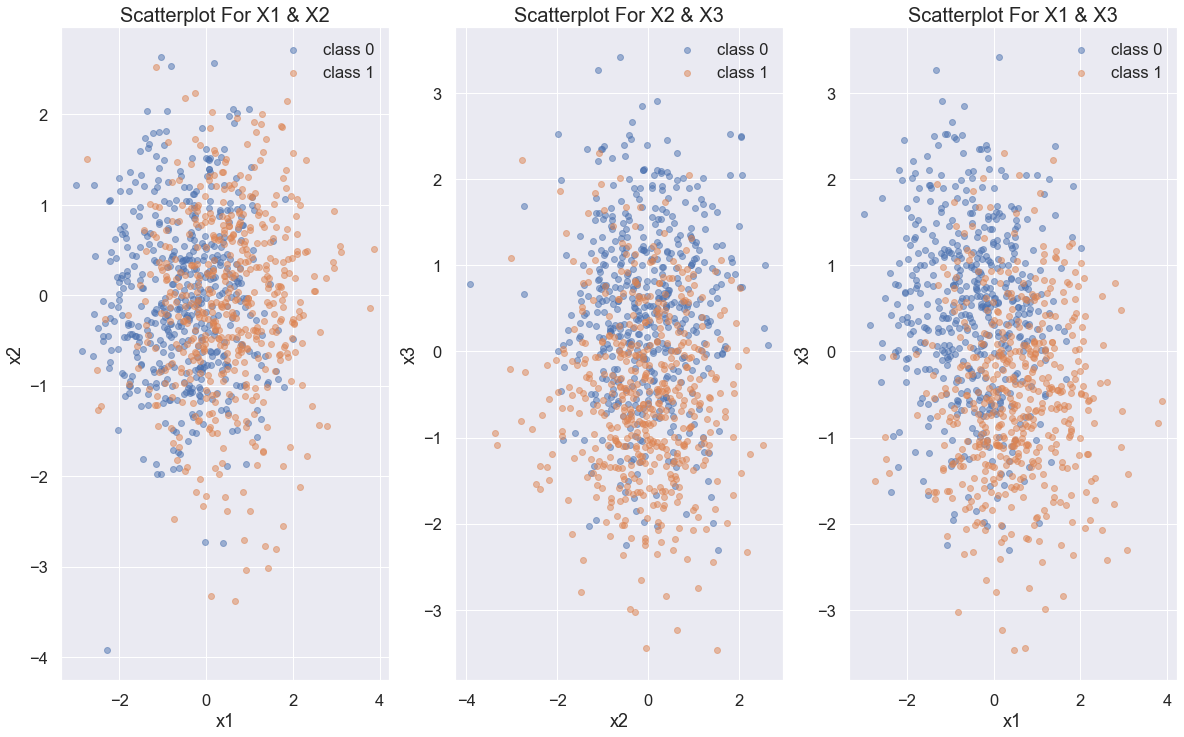

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 12))
ax[0].scatter(nb_better_df[nb_better_df.y == 0]["x1"].values, nb_better_df[training_set.y == 0]["x2"].values, alpha=0.5, label="class 0")
ax[0].scatter(nb_better_df[nb_better_df.y == 1]["x1"].values, nb_better_df[training_set.y == 1]["x2"].values, alpha=0.5, label="class 1")
ax[0].set_title('Scatterplot for x1 & x2'.title(), fontsize=20)
ax[0].legend()
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")

ax[1].scatter(nb_better_df[nb_better_df.y == 0]["x2"].values, nb_better_df[training_set.y == 0]["x3"].values, alpha=0.5, label="class 0")
ax[1].scatter(nb_better_df[nb_better_df.y == 1]["x2"].values, nb_better_df[training_set.y == 1]["x3"].values, alpha=0.5, label="class 1")
ax[1].set_title('Scatterplot for x2 & x3'.title(), fontsize=20)
ax[1].legend()
ax[1].set_xlabel("x2")
ax[1].set_ylabel("x3")

ax[2].scatter(nb_better_df[nb_better_df.y == 0]["x1"].values, nb_better_df[training_set.y == 0]["x3"].values, alpha=0.5, label="class 0")
ax[2].scatter(nb_better_df[nb_better_df.y == 1]["x1"].values, nb_better_df[training_set.y == 1]["x3"].values, alpha=0.5, label="class 1")
ax[2].set_title('Scatterplot for x1 & x3'.title(), fontsize=20)
ax[2].legend()
ax[2].set_xlabel("x1")
ax[2].set_ylabel("x3")
plt.show()